<a href="https://colab.research.google.com/github/RoetGer/decisions-under-uncertainty/blob/main/forecasting_sorrows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The Sorrows Of A Data Scientist



In [1]:
! pip install sktime

     |████████████████████████████████| 5.7MB 6.1MB/s 
     |████████████████████████████████| 22.3MB 1.7MB/s 
     |████████████████████████████████| 9.5MB 36.4MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from graphviz import Digraph
from IPython.display import Image
from sktime.transformations.series.detrend import Deseasonalizer

plt.rc("figure", figsize=(15, 10))

**Imagine the following scenario**:

You are supposed to **optimize the price** of some product, e.g. the margin for FX-spot.

Let us assume that your business partners would like to optimize with respect to gross income (GI), i.e. GI = volume x price. 

Of course, volume will depend on price, so we actually have that **GI(p) = v(p) x p**, where v stands for volume.    

There is some historical pricing data which can be used to construct a model, so you feel like that a reasonable way to proceed is to fit a demand model (for the volume) and then find the price which maximizes the GI (where you use the demand model as a plug-in estimator for the volume)

To put it in a nutshell, the plan goes something like this:



1.   Fit a model, s.t. volume = f(price)
2.   Then optimize GI, i.e. f(price) x price, with respect to the price
3.   Profit

In [21]:
def get_data(seed=None, price=None):
    date_idx = pd.date_range(start="2014-01-01", end="2021-02-01")
    
    if seed:
        np.random.seed(seed)
    
    days = np.arange(date_idx.shape[0])
    annual_seas_term = 2*np.pi*days/365.25

    nterms = 5
    phase = np.random.normal(size=(nterms, 1))
    amplitude = np.random.normal(size=(nterms, 1))
    
    error = np.random.normal(scale=0.25, size=(nterms, annual_seas_term.shape[0]))
    fourier_terms = (
        amplitude * np.cos(
          np.outer(np.arange(1, 1 + nterms), annual_seas_term) + phase)
    )

    capacity = 1000*np.sqrt(np.exp(np.sum(fourier_terms + error, axis=0)))

    fourier_expert = 2.*np.cos(annual_seas_term + 2) #+ \
     # np.random.normal(scale=.15, size=days.shape[0])
    
    if price is None:
        price_fraction = 1/(1 + np.exp(-fourier_expert))
        price = 0.1 + price_fraction*2

    volume = capacity / (1 + np.exp(-2 + 3*price))
    gi = volume * price

    return pd.DataFrame({
        "price": price,
        "volume": volume,
        "gi": gi
    }, index=date_idx)


In [22]:
hist_price = get_data(seed=5)
hist_price

,price,volume,gi
2014-01-01,0.706321,871.876139,615.824084
2014-01-02,0.693237,670.456924,464.785376
2014-01-03,0.680423,447.910836,304.768799
2014-01-04,0.667882,783.434340,523.241516
2014-01-05,0.655615,625.065315,409.802441
...,...,...,...
2021-01-28,0.446111,1017.369309,453.859267
2021-01-29,0.440082,838.443619,368.984328
2021-01-30,0.434269,1392.114378,604.551627
2021-01-31,0.428665,631.008598,270.491342


In [23]:
hist_price.gi.mean()

234.830354225878

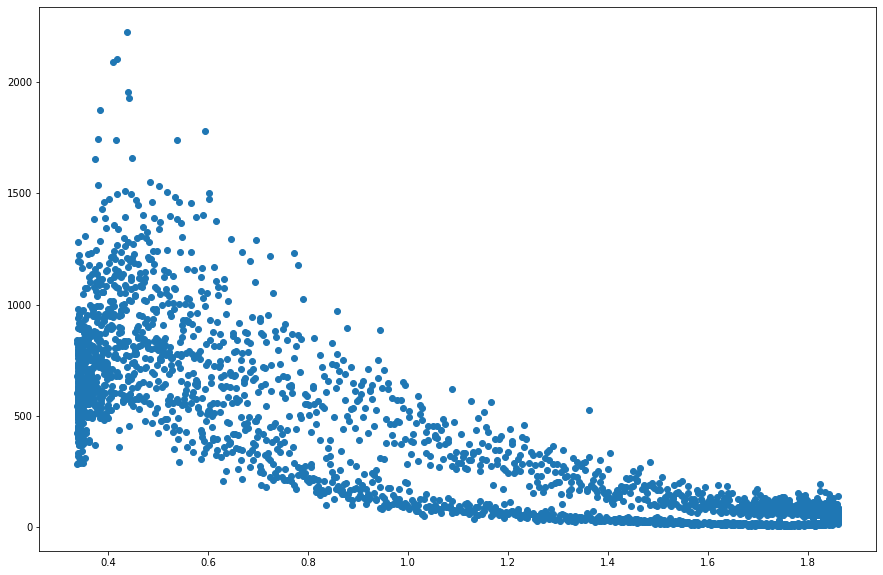

In [24]:
plt.scatter(hist_price.price, hist_price.volume)

In [41]:
print("Stationarity test for price:", 
    sm.tsa.stattools.adfuller(hist_price.price))
print("Stationarity test for volume:", 
    sm.tsa.stattools.adfuller(hist_price.volume))

Stationarity test for price: (-2.682447115556836, 0.07712524737778702, 6, 2582, {'1%': -3.4328851716021447, '5%': -2.8626600409837515, '10%': -2.5673662385423484}, -114884.59251605588)
Stationarity test for volume: (-5.192744378108689, 9.096966590936501e-06, 26, 2562, {'1%': -3.432904982050806, '5%': -2.8626687895063343, '10%': -2.567370896334526}, 33260.857035686226)


Volume seems to be fine, but price seems to have some small stationarity issue, let's take the first difference.

In [46]:
print("Stationarity test for price-diff:",
    sm.tsa.stattools.adfuller(hist_price.price.diff().dropna()))
hist_price["price_diff"] = hist_price.price.diff()
hist_price.dropna(inplace=True)

Stationarity test for price-diff: (-60.39669303841866, 0.0, 7, 2579, {'1%': -3.4328881235621926, '5%': -2.862661344607029, '10%': -2.567366932602502}, -138548.32765752796)


While the plot looks strange, the augmented Dickey-Fuller tests would indicate that volume and first-order difference of the price are stationary, so everything fine?

Text(0, 0.5, 'Volume')

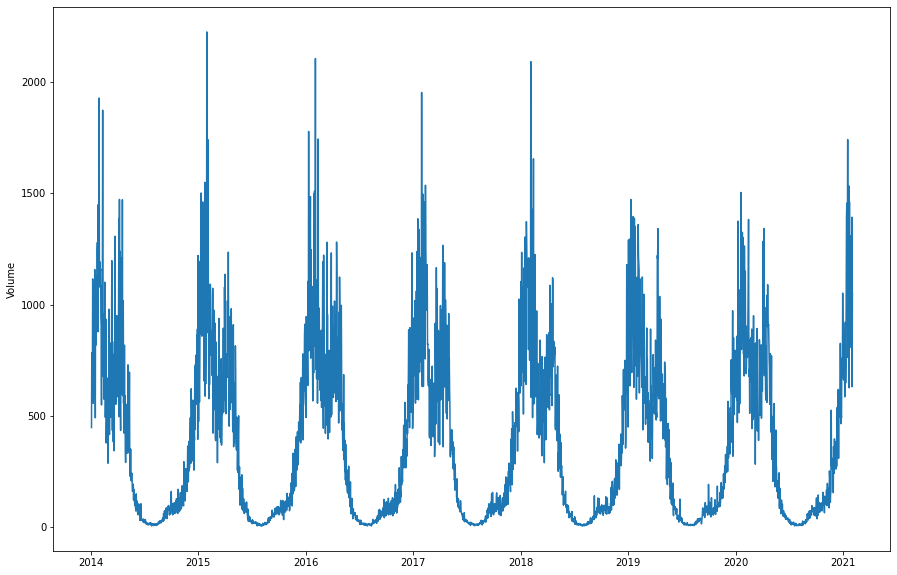

In [47]:
plt.plot(hist_price.volume)
plt.ylabel("Volume")

We can clearly see some seasonality in the plot, let's remove it by assuming that an annual seasonality is present in the data.

Text(0, 0.5, 'Seasonality-adjusted Volume')

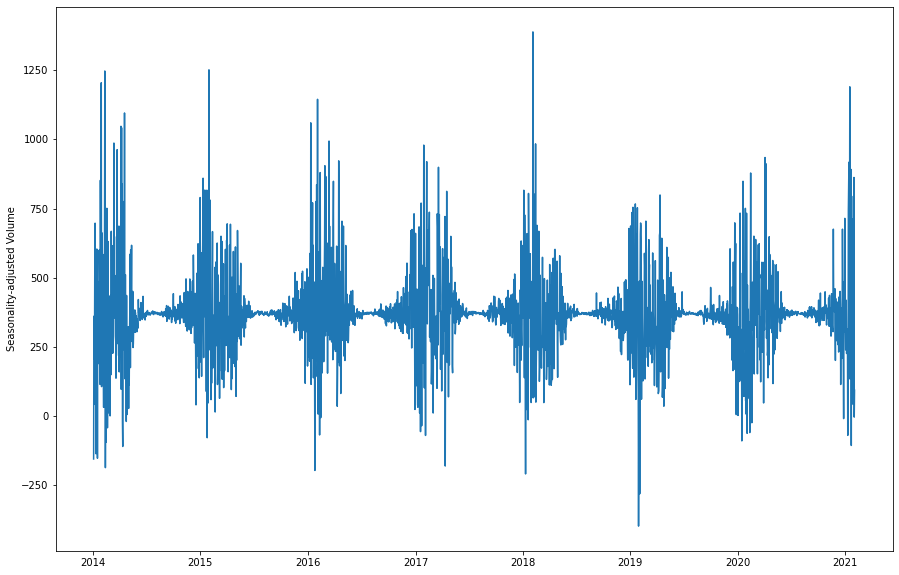

In [48]:
dseas = Deseasonalizer(sp=365)
dseas_volume = dseas.fit_transform(hist_price.volume)
plt.plot(dseas_volume)
plt.ylabel("Seasonality-adjusted Volume")

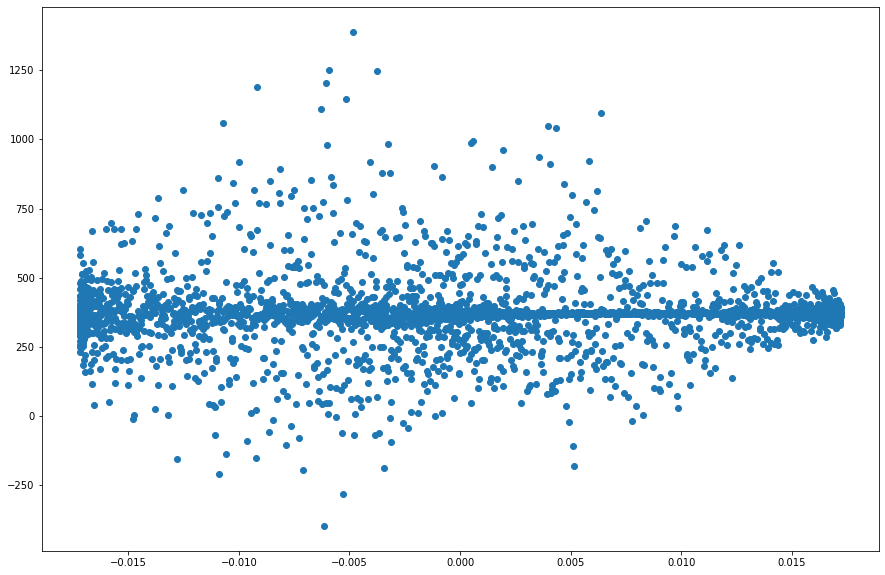

In [50]:
plt.scatter(hist_price.price_diff, dseas_volume)

Looks better, but there is still some unaddressed, temporal component in form of the different variance blocks. This is also reflected in the plot price against volume. Quite often such issues can be mitigated by using power transformations or simply taking the logarithm.

Text(0, 0.5, 'Seasonality-adjusted Log-Volume')

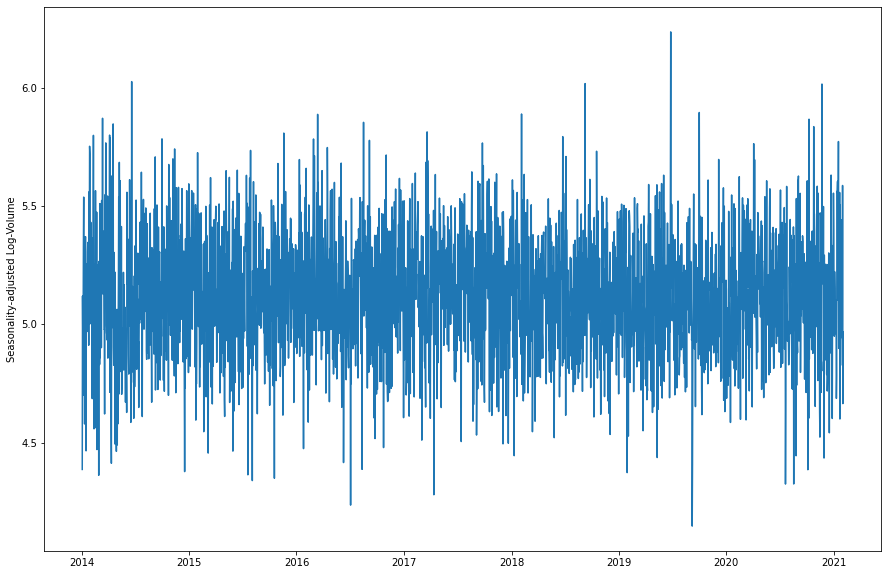

In [51]:
hist_price["log_volume"] = np.log(hist_price.volume)
hist_price["deseas_log_volume"] = dseas.fit_transform(hist_price.log_volume)
plt.plot(hist_price.deseas_log_volume)
plt.ylabel("Seasonality-adjusted Log-Volume")

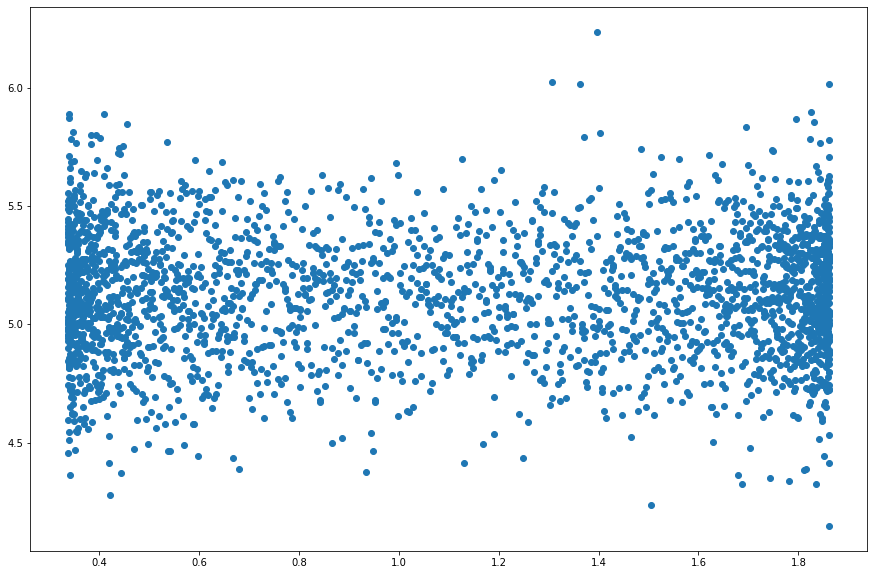

In [52]:
plt.scatter(hist_price.price, hist_price.deseas_log_volume)

Looks way better :)

Let's fit a model on the seasonality adjusted log volume against the difference in price. 

In [53]:
mdl = sm.OLS(
    hist_price.deseas_log_volume, 
    sm.add_constant(hist_price.price_diff))
mdl = mdl.fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      deseas_log_volume   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3845
Date:                Thu, 15 Apr 2021   Prob (F-statistic):              0.535
Time:                        08:07:51   Log-Likelihood:                -247.47
No. Observations:                2587   AIC:                             498.9
Df Residuals:                    2585   BIC:                             510.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1235      0.005    978.290      0.000       5.113       5.134
price_diff    -0.3227      0.520     -0.620      0.535      -1.343       0.698
==============================================================================
Omnibus:                        2.073   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.355   Jarque-Bera (JB):                2.072
Skew:                          -0.028   Prob(JB):                        0.355
Kurtosis:                       3.127   Cond. No.                         99.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

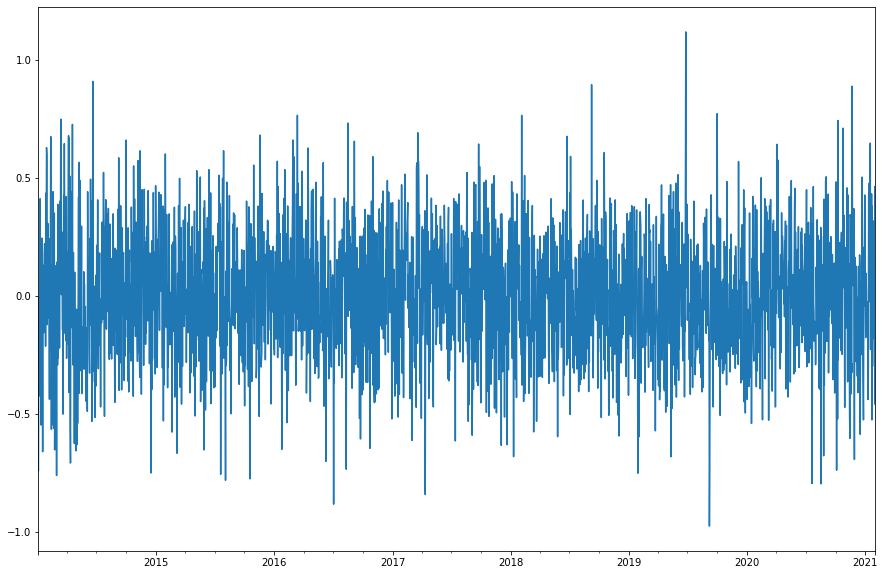

In [55]:
mdl.resid.plot()

Looks ok, there might be an issue with serial correlation in the residuals. Let's check for this as well.

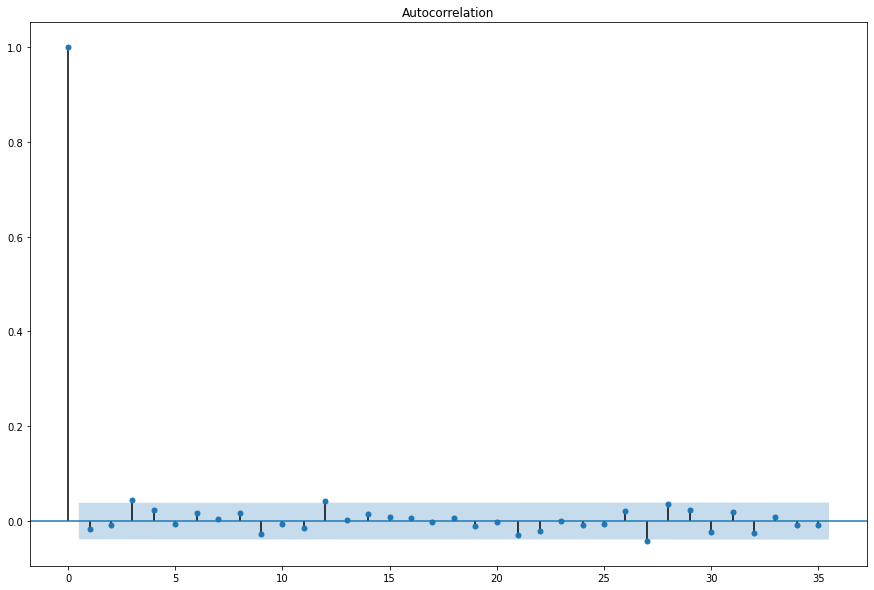

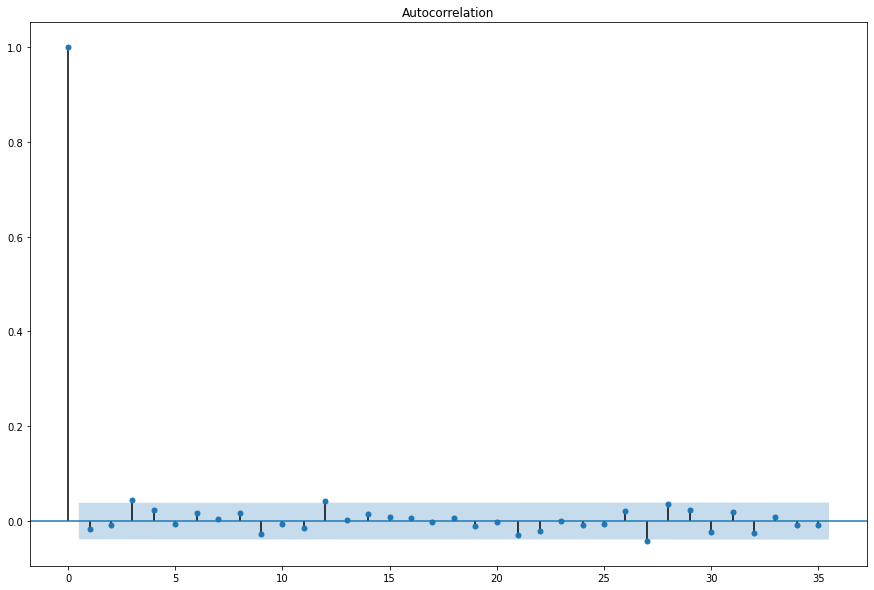

In [56]:
sm.tsa.graphics.plot_acf(mdl.resid)

Again seems reasonable, but maybe you are like: Regressing seas.-adj. log volume against difference in price feels a bit awkward. How about we fit differences in the seas.-adj log volume against differences in prices?

In [57]:
hist_price["deseas_log_volume_diff"] = hist_price.deseas_log_volume.diff()
hist_price.dropna(inplace=True)

mdl_deseas_diff = sm.OLS(
    hist_price.deseas_log_volume_diff, 
    sm.add_constant(hist_price.price_diff))
mdl_deseas_diff = mdl_deseas_diff.fit()
mdl_deseas_diff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     deseas_log_volume_diff   R-squared:                       0.000
Model:                                OLS   Adj. R-squared:                 -0.000
Method:                     Least Squares   F-statistic:                  0.001745
Date:                    Thu, 15 Apr 2021   Prob (F-statistic):              0.967
Time:                            08:21:08   Log-Likelihood:                -1163.5
No. Observations:                    2586   AIC:                             2331.
Df Residuals:                        2584   BIC:                             2343.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.007      0.030      0.976      -0.014       0.015
price_diff    -0.0310      0.742     -0.042      0.967      -1.486       1.424
==============================================================================
Omnibus:                        0.156   Durbin-Watson:                   3.005
Prob(Omnibus):                  0.925   Jarque-Bera (JB):                0.152
Skew:                           0.019   Prob(JB):                        0.927
Kurtosis:                       2.999   Cond. No.                         99.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Seems like our seasonally-adjusted models are doing fine. Surprisingly, it would suggest that the price does not have an impact on the volume, so turn it up to the max? 

Thanks to the fact that we are using simulated data, we can simply rerun the simulation with the higher price and check how much richer we made the company :)

In [58]:
# 2.1 is the highest allowed price set by Business
fixed_price = get_data(seed=5, price=2.1)

*drum roll*

In [59]:
print("GI for old approach: {:.2f}".format(hist_price.gi.mean()))
print("GI for new, data-driven approach: {:.2f}".format(fixed_price.gi.mean()))

GI for old approach: 234.57
GI for new, data-driven approach: 36.09


Great, we would have bankrupted the bank ... :(

What went wrong???

The issue is one of causality (as so often)

We were modelling under the assumption that the causal relationship looks a lot like this:

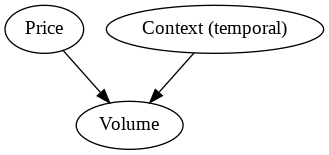

In [60]:
dot = Digraph()

dot.node("P", "Price")
dot.node("C", "Context (temporal)")
dot.node("V", "Volume")

dot.edges(["PV", "CV"])
dot.render("causal-graph1.cv", view=True, format="png")
Image('causal-graph1.cv.png')

While in reality, it was looking way more like this for the historical data:

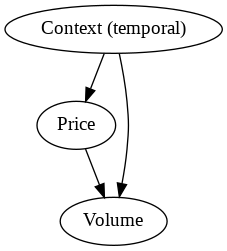

In [61]:
dot = Digraph()

dot.node("P", "Price")
dot.node("C", "Context (temporal)")
dot.node("V", "Volume")

dot.edges(["PV", "CV", "CP"])
dot.render("causal-graph2.cv", view=True, format="png")
Image('causal-graph2.cv.png')

Let's plot to see price and volume over time together.

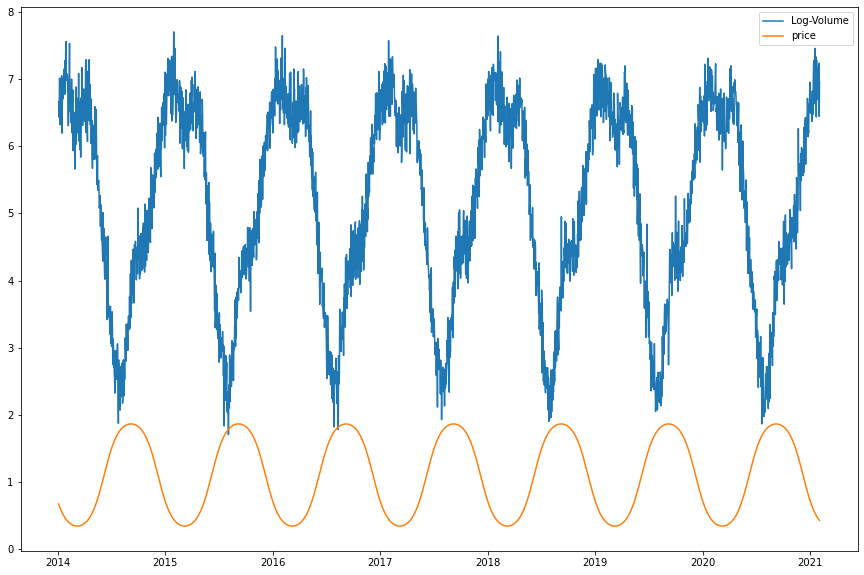

In [62]:
plt.plot(hist_price.log_volume, label="Log-Volume")
plt.plot(hist_price.price, label="price")
plt.legend(loc="best")

Clearly, the prices where not picked randomly, it seems like some strategy, where falling volumes were compensated with increasing margins and vice versa. This could have also happened in anticipation of falling/increasing volumes, so the seasonality information is somehow related with the changes in price --> it is hard to isolate whether high/low volumes are due to seasonality patterns or the prices.

Interestingly, if we were only concerned with prediction, this would have probably not consituted much of an issue, as in this case, all the predictive power seems to be already in the seasonality, so even if we had predicted out-of-sample only with the seasonality patterns, the results would have been decent. Of course, this only applies to the situation that we do not forefully change the dependence between temporal context and prices. But this is what we exactly did, by setting the prices to high in all situation, we broke the causal relationship. 

The whole situation gives rise to an interesting classification of data science use cases and their corresponding three questions they try to answer (based on Griffin's paper on Data Science ROI):

1. **Prediction**: What is happening?
2. **Causal Inference**: Why is it happening?
3. **Control**: What actions can I take?

In our case, we had a Control problem, but for this we need to identify the true underlying causal relationship between actions taken and outcome. Which we failed to do so for our pricing exercise.